# 05C. Modeling a box of 2D particles

### Mingyang Lu

### 2/12/2024

# Modeling multiple particles in a box

We consider $N_{tot} = 25$ identical particles in a two-dimensional square box of size $a = 6.25$. Below shows a configuration of the system where the particles are located at evenly distributed grid points.

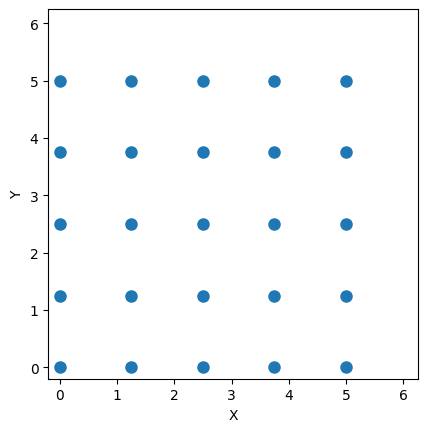

In [1]:
import numpy as np
import matplotlib.pyplot as plt

ntot = 25
a = 6.25
grid_x = np.arange(0, 5.1, 1.25)
grid_y = np.arange(0, 5.1, 1.25)
mat_xy = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)
xy0 = np.array(mat_xy)
plt.plot(xy0[:, 0], xy0[:, 1], marker='o', markersize=8, linestyle='')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-0.2, a)
plt.ylim(-0.2, a)
plt.gca().set_aspect('equal', adjustable='box') 
plt.show()

There are pairwise interactions between any two particles governed by the following force function:

$$F(r) = \frac{1}{r^{13}} - \frac{1}{r^7} \tag{1}.$$

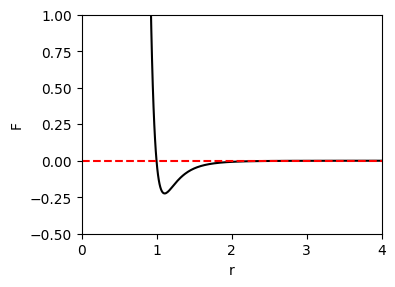

In [2]:
def force(r):
    r3 = r * r * r
    r6 = r3 * r3
    f = (1 / r6 / r6 - 1 / r6) / r
    return f

r_all = np.arange(0.01, 4.01, 0.01)
forces = np.array([force(r) for r in r_all])

plt.figure(figsize=(4, 3))
plt.subplots_adjust(bottom=0.15, left=0.15)

plt.plot(r_all, forces, color='black')
plt.xlabel('r')
plt.ylabel('F')
plt.xlim(0, 4)
plt.ylim(-0.5, 1)
plt.axhline(y=0, linestyle='--', color='red')

plt.show()

$r$ is the Euclidean distance between the particles. The force in Equation (1) is attractive (*i.e.*, $F(r) < 0$) for $r > 1$ and repulsive (*i.e.*, $F(r) > 0$) for $0 < r < 1$. The masses of all particles are 1. Note, this force function correponds to the famous Lennard Jones (LJ) potential.

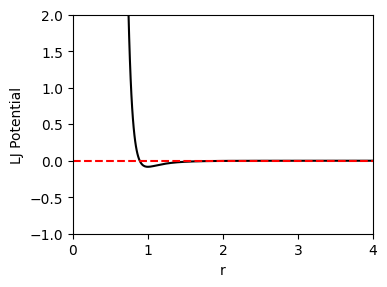

In [3]:
def E_LJ(r):
    r3 = r * r * r
    r6 = r3 * r3
    e = 1 / (12 * r6 * r6) - 1 / (6 * r6)
    return e

r_all = np.arange(0.01, 4.01, 0.01)
energies = np.array([E_LJ(r) for r in r_all])

plt.figure(figsize=(4, 3))
plt.subplots_adjust(bottom=0.15, left=0.15)

plt.plot(r_all, energies, color='black')
plt.xlabel('r')
plt.ylabel('LJ Potential')
plt.xlim(0, 4)
plt.ylim(-1, 2)
plt.axhline(y=0, linestyle='--', color='red')

plt.show()

# Periodic boundary condition & minimum image convention

In this simulation, we consider the periodic boundary condition in that particles travel outside of the box would go inside the box from the other side. To update the position x (a vector of size 2) of a particle:

In [4]:
x = np.array([-5.5, 4.2])
a = 2
xnew = x - np.floor(x / a) * a # floor: the largest integer below x/a
print("x:", x)
print("xnew:", xnew)

x: [-5.5  4.2]
xnew: [0.5 0.2]


There is no need to update the velocities. 

Using the periodic boundary condition, we simulate a small box of particles to model the behavior of a much larger system consisting of the repetitive boxes. Since each particle can now present a lattice of particles of images, there are an infinite number of interactions to consider between any two particles $i$ and $j$. A common way to address this is to consider the *minimum image convention*, where individual particle in the simulation interacts with the closest image of the remaining particles in the system. 

To compute the corresponding distance between two particles $i$ and $j$, we

In [5]:
xi = np.array([0.7, 1.9])
xj = np.array([1.8, 1.2])
a = 2

dx = xj - xi  # a vector of size 2
r1 = np.sqrt(np.sum(dx * dx))  # distance directly from xi and xj

dx = dx - np.round(dx / a) * a  # round: nearest integer
r_min = np.sqrt(np.sum(dx * dx))  # distance from the minimum image convention

print("r1:", r1)
print("r_min:", r_min)
print("Actual calculation in r_min:", np.sqrt((2.7 - 1.8) ** 2 + (1.9 - 1.2) ** 2))


r1: 1.3038404810405297
r_min: 1.1401754250991378
Actual calculation in r_min: 1.140175425099138


# Compute the total force 

Now we devise a function to compute the x and y components of the total force for each particle. 

The x-component of the force from particle $j$ to particle $i$ is 

$$f_x(j \rightarrow i) = F(r_{ij}) \frac{(x_i - x_j)}{r_{ij}}  \tag{2}$$
, where $r_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$. (Note that positive $F$ means repulsive interaction)

Similarly, the y-component of the force is

$$f_y(j \rightarrow i) = F(r_{ij}) \frac{(y_i - y_j)}{r_{ij}}  \tag{3}.$$
The total force of particle $i$ is the summation of the pairwise forces from any particle $j$ (where $j \ne i$) to particle $i$.


In [6]:
# x-y components of the force from j to i
def force_j2i(i, j, x_all, a):
    xi, yi = x_all[2*i-2:2*i]
    xj, yj = x_all[2*j-2:2*j]

    dx = xi - xj
    dx -= np.round(dx / a) * a
    dy = yi - yj
    dy -= np.round(dy / a) * a

    rij = np.sqrt(dx ** 2 + dy ** 2)
    fxi = force(rij) * dx / rij
    fyi = force(rij) * dy / rij
    return np.array([fxi, fyi])

# total force
def force_all(t, x_all, a):
    Ntot = len(x_all) // 2
    f = np.zeros(2 * Ntot)
    for i in range(1, Ntot):
        for j in range(i+1, Ntot+1):
            fij = force_j2i(i, j, x_all, a)
            f[2*i-2:2*i] += fij
            f[2*j-2:2*j] -= fij
    return f

The function *force_all* computes the forces from all pairwise interactions between the particles. The input argument for this function is a vector of size $2N_{tot}$ for the $x$ and $y$ coordinates. The output of this function is a vector of size $2N_{tot}$ for the $x$ and $y$ components of the total force $f$ for each particle. 

# Update positions by the periodic boundary condition

After every MD integration step, particle positions need to be adjusted according to the periodic boundary condition.

In [7]:
def bc_periodic(x_all, a):
    x_all_new = x_all - np.floor(x_all / a) * a
    return x_all_new

# Verlocity Verlet (periodic boundary condition)

We simulated the dynamics of the particles according to

$$ m_i\frac{d^2x_i}{dt^2} = \sum_{j\neq i}{f_x(j\rightarrow i)}  \tag{4}$$

, where $m_i = 1$ (thus can be omitted) and the summation from the right hand side is over all particles other than $i$. A similar equation is needed for $y_i$. 

In [8]:
# Velocity Verlet method for high dimensional systems (2D, 3D, or multiple particles)
# Updated with periodic boundary condition
def velocity_verlet_bc(f, t0, x0, v0, t_total, dt, **kwargs):
    # f:  2nd derivative function
    # t0: initial time
    # x0: a vector of initial position x
    # v0: a vector of initial velocity v
    # t_total: total simulation time
    # dt: time step size 
    t_all = np.arange(t0, t_total + dt, dt)
    nt_all = len(t_all)
    nx = len(x0)
    x_all = np.zeros((nt_all, nx))
    v_all = np.zeros((nt_all, nx))
    x_all[0] = x0
    v_all[0] = v0 
    for i in range(1, nt_all):
        v_half = v_all[i - 1] + 0.5 * dt * f(t_all[i - 1], x_all[i - 1], **kwargs)
        x_all[i] = x_all[i - 1] + dt * v_half
        v_all[i] = v_half + 0.5 * dt * f(t_all[i], x_all[i], **kwargs)
        
        x_all[i,] = bc_periodic(x_all[i,], **kwargs)
    return np.hstack((t_all.reshape(-1, 1), x_all, v_all))   # the output is a matrix of t, x, v for all time steps

# Initial simulation for t.total = 10

We now perform a dynamics simulation of the box of the $N_{total}=25$ particles using the velocity Verlet method. For the initial condition, we use evenly distributed grid points for the particle positions $x$ and $y$ (see the first figure). We use random velocities in the range of (-0.05, 0.05) for both $v_x$ and $v_y$. The initial simulation takes a short simulation (t.total $= 10$). Time step size $dt = 0.01$. 


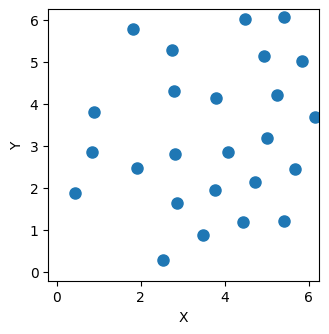

In [9]:
np.random.seed(11)

ntot = 25
a = 6.25
grid_x = np.arange(0, 5.01, 1.25)
grid_y = np.arange(0, 5.01, 1.25)
mat_xy = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)
x0 = mat_xy.flatten()
v0 = np.random.uniform(low=-0.05, high=0.05, size=ntot*2)

results_init = velocity_verlet_bc(f = force_all, t0 = 0, x0 = x0, v0 = v0, 
                                  t_total = 10, dt = 0.01, a = a)
nt_all = results_init.shape[0]
init_last_step = results_init[-1]

x0 = init_last_step[1:ntot*2+1]
v0 = init_last_step[ntot*2+1:]

xy0 = np.array(x0).reshape(-1, 2)
plt.figure(figsize=(3.5, 4))
plt.plot(xy0[:, 0], xy0[:, 1], marker='o', markersize=8, linestyle='')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-0.2, a)
plt.ylim(-0.2, a)
plt.gca().set_aspect('equal', adjustable='box') 
plt.show()

The plot shows the particles' positions from the last time point of the initial simulation in a 2D scatter plot. 

# Final simulation for t.total = 100

After the initial simulation, the system should reach to an "equilibrium" -- a more disordered configuration. Now, we continue to perform a longer simulation for t.total $= 100$. (Before you run this simulation, check the time cost from the initial simulation to estimate the waiting time for this longer simulation.) 

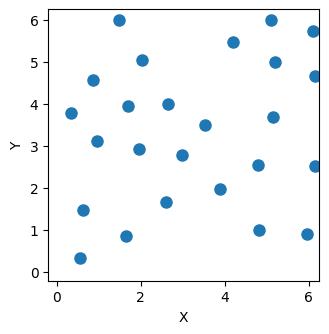

In [10]:
results_final = velocity_verlet_bc(f = force_all, t0 = 0, x0 = x0, v0 = v0, 
                                  t_total = 100, dt = 0.01, a = a)
nt_all = results_final.shape[0]
final_last_step = results_final[-1]

x_f = final_last_step[1:ntot*2+1]
xy_f = np.array(x_f).reshape(-1, 2)

plt.figure(figsize=(3.5, 4))
plt.plot(xy_f[:, 0], xy_f[:, 1], marker='o', markersize=8, linestyle='')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-0.2, a)
plt.ylim(-0.2, a)
plt.gca().set_aspect('equal', adjustable='box') 
plt.show()

# Radial distribution function

After the simulation has completed, we use the whole time trajectories of all particles to compute the radial distribution function (RDF), $g(r)$. $g(r)$ measures the probability of finding a particle at distance $r$ from a reference particle, relative to the probability of finding the same particle at $r$ in a uniform distribution. 

$$g(r) = \frac{<\rho(r)>}{\rho_0} = \frac{<\Delta N(r)>}{2\pi r \Delta r\rho_0}.  \tag{5}$$ 

$\rho_0$ is the particle density:

$$\rho_0 = \frac{N_{tot}}{a^2}.$$

$\rho(r)$ is the local density of the particles at distance $r$ away from a reference particle. Thus, $<\Delta N(r)>$ is the average number of particles at a shell at distance $r$ and of thickness $\Delta r$ (red particles) from a reference particle (orange particle). 

$<>$ is the operation of averaging over all particles and all time points during this current simulation. Write a function to compute $g(r)$ for a series of $r$ values until $a/2$ (why?) with an interval $\Delta r = 0.05$. Here, you will need to count the number of particles in a shell between $r$ to $r + \Delta r$ and then perform the averaging. Plot $g(r)$. The minimum image convention needs to be considered when computing the distances.

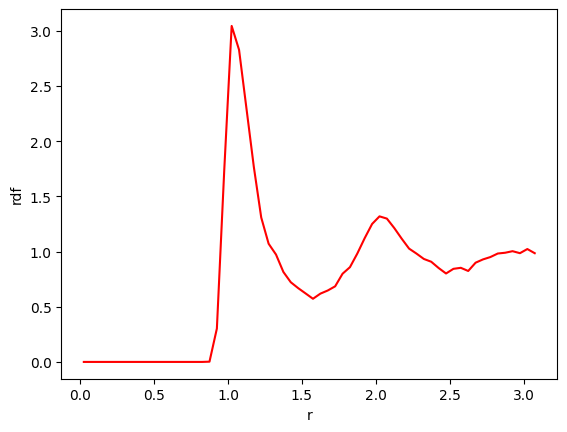

In [11]:
def cal_rdf(ntot, results, a, dr):
    # ntot: number of particles
    # results: simulation output matrix
    # a: box size
    # dr: bin size
    nt_all = results.shape[0]
    r_all = np.arange(dr, a/2, step=dr)
    nr = len(r_all)
    counts = np.zeros(nr)

    for nt in range(nt_all):
        x_all = results[nt, 1:(2*ntot):2]
        y_all = results[nt, 2:(2*ntot+1):2]

        for i in range(ntot):
            xi = x_all[i]
            yi = y_all[i]

            for j in range(ntot):
                if i != j:
                    xj = x_all[j]
                    yj = y_all[j]

                    dx = xi - xj
                    dx -= np.round(dx/a) * a
                    dy = yi - yj
                    dy -= np.round(dy/a) * a

                    rij = np.sqrt(dx**2 + dy**2)
                    ind = int(np.ceil(rij/dr))

                    if ind < nr:
                        counts[ind] += 1

    r_mean = r_all - 0.5 * dr
    rho = counts / (nt_all * ntot * 2 * np.pi * dr * r_mean)
    rho_0 = ntot / a**2
    rdf = rho / rho_0

    return r_mean, rdf

r, rdf = cal_rdf(ntot = ntot, results = results_final, 
                 a = a, dr = 0.05)

plt.plot(r, rdf, color='red')
plt.xlabel('r')
plt.ylabel('rdf')
plt.show()

The shape of the RDF is typical for a liquid system. RDF ~ 0 below $r = 0.8$ due to strong repulsive interactions from the LJ force. There is a sharp peak near $r = 1$, representing the first coordinate shell. The second peak at $r ~ 2$ is supposed to correspond to the second coordinate shell. The third peak is very close to 1. The second and third peaks are much lower than the first peak due to short-range order and long-range disorder. 

Please note:

* Here, we modeled a 2D system. This simulation can be easily generalized to 3D for modeling more realistic systems. Some properties in 3D may be different from those in 2D.

* For illustration in Python, we chose very large time step size and short simulation time. To obtain more robust results, one needs to use much smaller time step size and longer simulations.